In [12]:
import numpy as np
from plotting import plotTF, plotTFs
import matplotlib.pyplot as plt                 #For plotting
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
figlist = []

#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
#********************************************************************************************************
import scipy.signal
from scipy.optimize import curve_fit, least_squares

In [2]:
def stitchData(fileList):
    data = np.loadtxt(fileList[0])
    for ii in range(1,len(fileList)):
        temp = np.loadtxt(fileList[ii])
        for jj in range(len(temp[:, 0])):
            if temp[jj, 0] > data[-1, 0]:
                break
        data = np.vstack([data, temp[jj:,:]])
    return data

In [5]:
G1=-392/124          #Gain of stage across which OUT1 and OUT2 are present
NorthData = stitchData(['North_FSS_OUT1_over_OUT2_03-10-2019_160446.txt',
                        '../20191002_FSS_OLTFs/NorthLF_OUT1_over_OUT2_02-10-2019_192035.txt',
                        '../20191002_FSS_OLTFs/NorthHF_OUT1_over_OUT2_02-10-2019_192324.txt'])
SouthData = stitchData(['South_FSS_OUT1_over_OUT2_03-10-2019_105617.txt',
                        '../20191002_FSS_OLTFs/SouthLF_OUT1_over_OUT2_02-10-2019_192656.txt',
                        '../20191002_FSS_OLTFs/SouthHF_OUT1_over_OUT2_02-10-2019_192929.txt'])
North = G1*NorthData[:,1]*np.exp(1j*NorthData[:,2]*np.pi/180)
South = G1*SouthData[:,1]*np.exp(1j*SouthData[:,2]*np.pi/180)
ff = NorthData[:,0]
Northfug = ff[np.argmin(np.abs(np.abs(North)-1))]/1e3
Southfug = ff[400+np.argmin(np.abs(np.abs(South[400:])-1))]/1e3

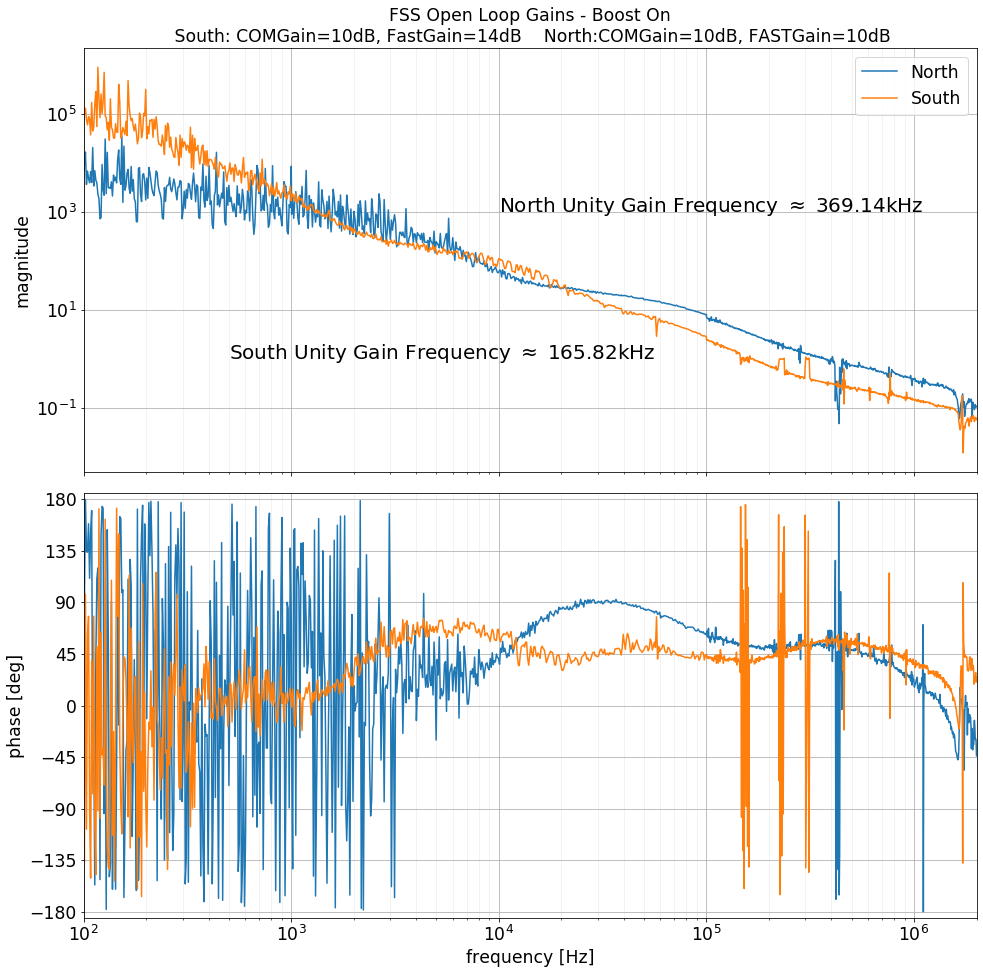

In [6]:
fig = plotTF(ff,North,figsize=[16,16],dB=False, label='North');
plotTF(ff,South,mag_ax=fig.axes[0],phase_ax=fig.axes[1],dB=False,label='South');
ax = fig.axes[0]
fig.axes[0].text(1e4,1e3,r'North Unity Gain Frequency $\approx$ '+str(np.round(Northfug,2))+ 'kHz',FontSize=20)
fig.axes[0].text(500,1,r'South Unity Gain Frequency $\approx$ '+str(np.round(Southfug,2))+ 'kHz',FontSize=20)
ax.set_xlim((100,2e6))
ax.legend()
ax.set_title('FSS Open Loop Gains - Boost On\n South: COMGain=10dB, FastGain=14dB    North:COMGain=10dB, FASTGain=10dB');
figlist = [fig]

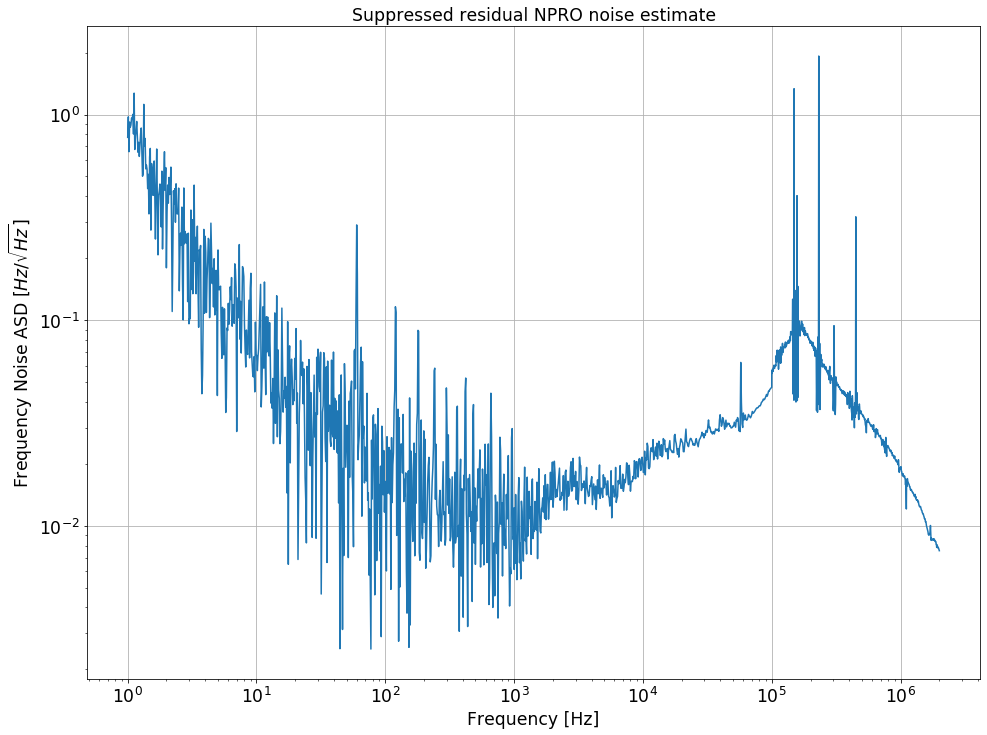

In [7]:
nproFreeASD = 10**4/ff # Hz/Hz**0.5
northResidFreqPSD = (nproFreeASD / np.abs(1-North))**2
southResidFreqPSD = (nproFreeASD / np.abs(1-South))**2
residFreqASD = np.sqrt(northResidFreqPSD + southResidFreqPSD)
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
ax.loglog(ff, residFreqASD)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Frequency Noise ASD [$Hz/\sqrt{Hz}$]')
ax.grid()
ax.set_title('Suppressed residual NPRO noise estimate')
figlist += [fig]

In [25]:
def ZPKmodel(ff, *p):
    noz=3
    nop=5
    zeros = np.zeros(noz)*1j
    poles = np.zeros(nop)*1j
    for ii in range(noz):
        zeros[ii] = p[2*ii] + 1j*p[2*ii + 1]
    for jj in range(nop):
        poles[jj] = p[1*ii+1+2*jj] + 1j*p[2*ii+2*jj+2]
    gain = p[-1]
    model = scipy.signal.lti(zeros, poles, gain)
    freq, TF = model.freqresp(w=2*np.pi*ff)
    return TF

def costSouth(p):
    return np.abs(np.abs(South)-np.abs(ZPKmodel(ff,*p)))

In [35]:
fitSouth = least_squares(costSouth, np.array([-7.11579868e+03, -2.19722031e+06, -2.16027599e+04,  9.49582256e+05,
       -6.75751973e+03,  5.88362821e+05, -3.33764131e+02, -4.35743660e-09,
        3.70928192e+02, -4.35743661e-09,  9.41479831e+02,  1.09848013e-08,
        3.66393018e+02,  2.63478269e-27,  9.37028701e+02,  9.54640493e-47,
        2.19001114e+06]))#,
                                # bounds=([20e-9,600e-7,1e2,20e-9],[20e-7,600e-5,1e7,100]))

In [36]:
fitSouth.x

array([-7.76755034e+03, -2.40154421e+06, -3.04592031e+04,  1.37767719e+06,
       -8.53802562e+03,  5.88362821e+05, -3.33237413e+02, -4.35743656e-09,
        3.66361219e+02, -4.35743661e-09,  9.35625733e+02,  1.09848013e-08,
        3.66393018e+02,  2.63478269e-27,  9.37028701e+02,  9.54640493e-47,
        2.39897499e+06])

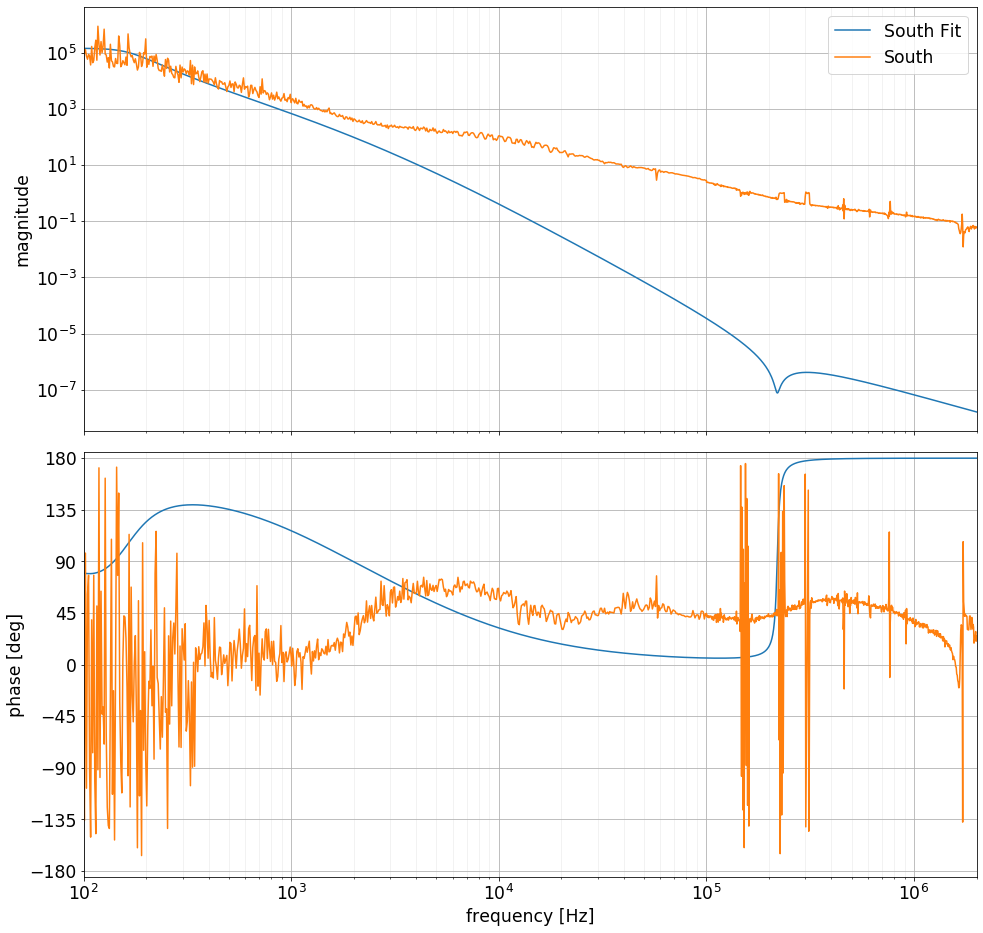

In [37]:
fig = plotTF(ff,ZPKmodel(ff, *fitSouth.x),figsize=[16,16],dB=False, label='South Fit');
plotTF(ff,South,mag_ax=fig.axes[0],phase_ax=fig.axes[1],dB=False,label='South');
ax = fig.axes[0]
ax.set_xlim((100,2e6))
ax.legend()
#ax.set_title('FSS Open Loop Gains - Boost On\n South: COMGain=10dB, FastGain=14dB    North:COMGain=10dB, FASTGain=10dB');
figlist = [fig]

In [ ]:
pp = PdfPages('FSS_OLTF.pdf')
for fig in figlist:
    pp.savefig(fig,bbox_inches='tight')
pp.close()